# Physics-informed neural network (PINN) demo

In this demo we will code a PINN from scratch in `Julia (Flux.jl)` and use it to solve simulation and inversion problems related to the damped harmonic oscillator.

In [1]:
using Flux
using Zygote
using Random
using Statistics
using Plots
using Optimisers
using ForwardDiff
using ProgressBars
using Printf
using Functors

## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

>Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

## Initial setup

First, we define a few helper functions.

In [3]:
# Analytical solution to the under-damped harmonic oscillator
function exact_solution(d, w0, t)
    @assert d < w0
    w = sqrt(w0^2 - d^2)
    ϕ = atan(-d / w)
    A = 1 / (2 * cos(ϕ))
    cos_term = cos.(ϕ .+ w .* t)
    exp_term = exp.(-d .* t)
    return exp_term .* 2 .* A .* cos_term
end

# Fully-connected network constructor in Flux
fcn(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS) = Chain(
    Dense(N_INPUT, N_HIDDEN, tanh),
    [Dense(N_HIDDEN, N_HIDDEN, tanh) for _ in 1:(N_LAYERS-1)]...,
    Dense(N_HIDDEN, N_OUTPUT)
)

fcn (generic function with 1 method)

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

For this task, we use $\delta=2$, $\omega_0=20$, $m=1$, and try to learn the solution over the domain $t\in [0,1]$.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `Zygote.gradient` (via Flux):

<img src="autograd_grad.png" width="800" align="left">

In [15]:
Random.seed!(123)

pinn = fcn(1, 1, 32, 3)

# --- FIX 1: Use Float32 for all inputs ---
boundaryₜ = 0.0f0
physicsₜ = collect(range(0.0f0, 1.0f0, length=30)) # Float32 range
d, w₀ = 2.0f0, 20.0f0
μ, k = 2 * d, w₀^2
testₜ = collect(range(0.0f0, 1.0f0, length=300)) # Float32 range
# --- End Fix 1 ---

opt = Optimisers.ADAM(1e-6)
optState = Optimisers.setup(opt, pinn)

# --- FIX 2: Define ALL derivative functions *outside* the loop ---
# They must take the model 'm' as an argument.

# Scalar network output
networkOutputScalar(m, t) = only(m(reshape([t], 1, 1)))

# Callable function u(t) for a given model m
u(m, t) = networkOutputScalar(m, t)

# First derivative u'(t) for a given model m
uₜ(m, t) = Zygote.gradient(tVal -> u(m, tVal), t)

# Second derivative u''(t) for a given model m
uₜₜ(m, t) = Zygote.gradient(tVal -> uₜ(m, tVal), t)
# --- End Fix 2 ---

println("Starting training...")
training = ProgressBar(1:15000)
for epoch in training
    # Also make lambdas Float32
    λ₁, λ₂ = Float32(1e-1), Float32(1e-5)

    # The gradient function is now "clean" and just calls the
    # functions defined above, passing 'm' to them.
    ∇data = Flux.gradient(m -> begin
        
        # Boundary condition 1: u(0) = 1
        u₀ = u(m, boundaryₜ) # Pass 'm'
        println("u₀: ", u₀)
        l₁ = (u₀ - 1.0f0)^2

        # Boundary condition 2: du/dt(0) = 0
        du₀ = uₜ(m, boundaryₜ) # Pass 'm'
        println("du₀: ", du₀)
        l₂ = (du₀ .- 0.0f0)^2

        # Physics loss over domain
        uᵥ = [u(m, t) for t in physicsₜ]    # Pass 'm'
        duᵥ = [uₜ(m, t) for t in physicsₜ]   # Pass 'm'
        d²uᵥ = [uₜₜ(m, t) for t in physicsₜ] # Pass 'm'

        l₃ = mean((d²uᵥ .+ μ .* duᵥ .+ k .* uᵥ) .^ 2)

        loss = l₁ + λ₁ * l₂ + λ₂ * l₃

        # Return loss (for gradient) and extra data (for printing)
        return loss
    end, pinn)

    # ∇data[1] contains the gradient for 'pinn'
    ∇pinn = ∇data[1] 
    optState, pinn = Optimisers.update!(optState, pinn, ∇pinn)

    # We must re-run the loss functions with the *new* pinn
    # to get the current loss values for printing.
    l₁Print = (u(pinn, boundaryₜ) - 1.0f0)^2
    l₂Print = (uₜ(pinn, boundaryₜ) - 0.0f0)^2
    
    uᵥPrint = [u(pinn, t) for t in physicsₜ]
    duᵥPrint = [uₜ(pinn, t) for t in physicsₜ]
    d²uᵥPrint = [uₜₜ(pinn, t) for t in physicsₜ]
    l₃Print = mean((d²uᵥPrint .+ μ .* duᵥPrint .+ k .* uᵥPrint) .^ 2)
    
    totalLossPrint = l₁Print + λ₁ * l₂Print + λ₂ * l₃Print
    set_description(training, string(@sprintf("Loss: %.2f", totalLossPrint)))
end

Starting training...


0.0%┣                                           ┫ 0/15.0k [00:00<-1:-36, -0s/it]


u₀: 0.0
du₀: (0.7000494f0,)


MethodError: MethodError: no method matching ^(::Tuple{Float32}, ::Int64)
The function `^` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  ^(!Matched::Regex, ::Integer)
   @ Base regex.jl:913
  ^(!Matched::Missing, ::Integer)
   @ Base missing.jl:155
  ^(!Matched::Missing, ::Number)
   @ Base missing.jl:123
  ...


## Task 2: train a PINN to invert for underlying parameters

#### Task

The second task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement, $u_{\mathrm{obs}}$
- Outputs: estimate $\mu$, the coefficient of friction

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

However here we assume $\mu$ is **not known** and we treat it as an additional **learnable parameter** when training the PINN.

#### Loss function

The PINN is trained with the loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( N\!N(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

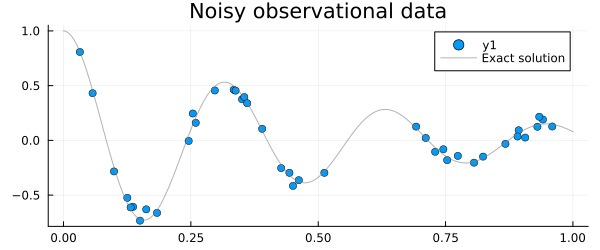

In [11]:
# first, create some noisy observational data
Random.seed!(123)
d, w0 = 2.0, 20.0
println("True value of mu: $(2*d)")
t_obs = rand(40)
u_obs = exact_solution(d, w0, t_obs) .+ 0.04 .* randn(40)
t_test = collect(range(0.0, 1.0, length=300))
u_exact = exact_solution(d, w0, t_test)

plt = plot(size=(600,250), title="Noisy observational data")
scatter!(plt, t_obs, u_obs)
plot!(plt, t_test, u_exact, label="Exact solution", color=:gray, alpha=0.6)
display(plt)

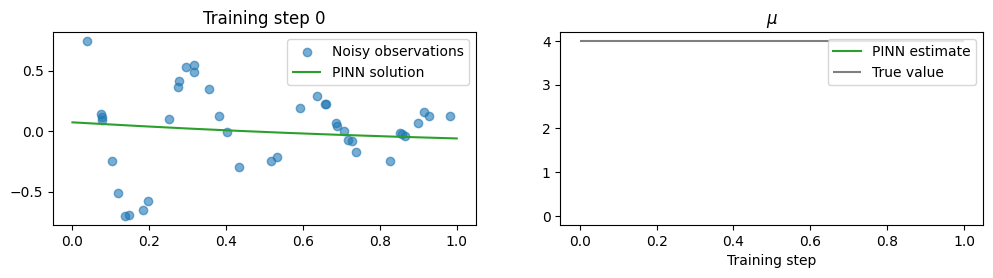

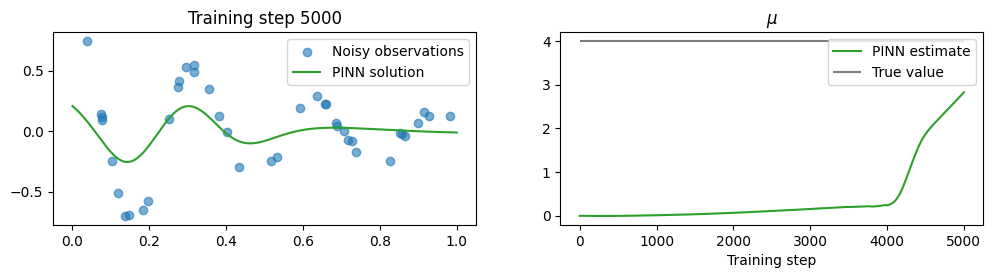

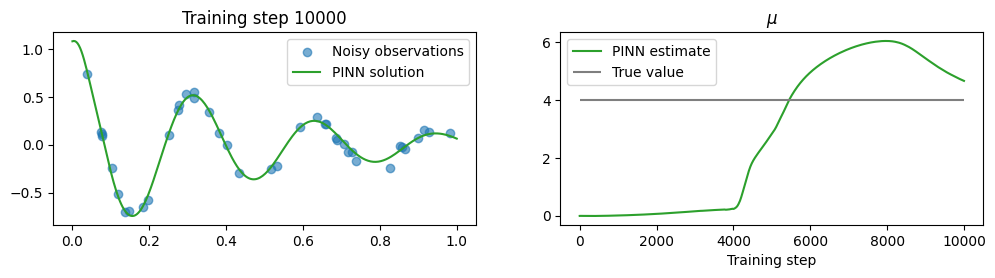

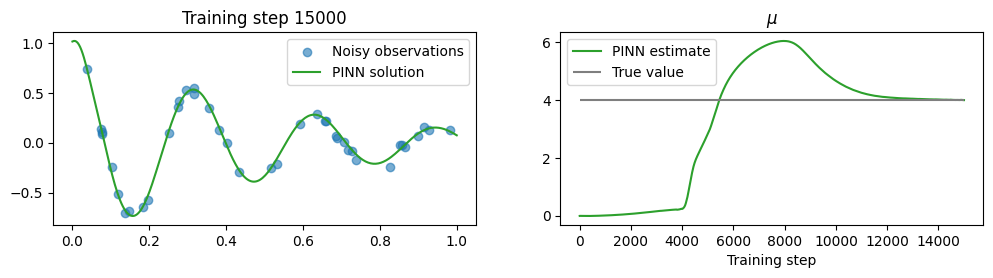

In [ ]:
Random.seed!(123)

# define a neural network to train
pinn = fcn(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = collect(range(0.0, 1.0, length=30))

# train the PINN
d, w0 = 2.0, 20.0
_, k = 2*d, w0^2
t_test = collect(range(0.0, 1.0, length=300))
u_exact = exact_solution(d, w0, t_test)

# treat mu as a learnable parameter, add it to optimiser
μ = Flux.param(0.0)
opt = Flux.Optimise.ADAM(1e-3)
ps = Flux.params(pinn, μ)
mus = Float64[]
for i in 0:15000
    λ1 = 1e4
    loss() = begin
        # physics loss
        u = u_vec(t_physics)
        du = dudt_scalar.(t_physics)
        d2u = d2udt2_scalar.(t_physics)
        l1 = mean((d2u .+ μ[] .* du .+ k .* u).^2)
        # data loss
        up = u_vec(t_obs)
        l2 = mean((up .- u_obs).^2)
        l1 + λ1*l2
    end
    gs = Flux.gradient(() -> loss(), ps)
    Flux.Optimise.update!(opt, ps, gs)
    push!(mus, μ[])
    if i % 5000 == 0
        u_pred = u_vec(t_test)
        p1 = plot(t_obs, u_obs, seriestype=:scatter, label="Noisy observations", alpha=0.6, color=:blue)
        plot!(p1, t_test, u_pred, label="PINN solution", color=:green)
        title!(p1, "Training step $i")
        p2 = plot(1:length(mus), mus, label="PINN estimate", color=:green, xlabel="Training step", title="μ")
        hline!(p2, [2*d], label="True value", color=:gray)
        display(plot(p1, p2, layout=(1,2), size=(1200,250)))
    end
end